Sentiment Classification Model to Distinguish between Positive and Negative Movie Reviews

# imports

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import io
import os

# load dataset

In [4]:
# make directory

os.mkdir('./data')

In [6]:
imdb, info = tfds.load('imdb_reviews',
                       with_info=True,
                       as_supervised=True,
                       data_dir='./data',
                       download=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling data/imdb_reviews/plain_text/incomplete.FK6CCE_1.0.0/imdb_reviews-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling data/imdb_reviews/plain_text/incomplete.FK6CCE_1.0.0/imdb_reviews-test.tfrecord*...:   0%|          …

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling data/imdb_reviews/plain_text/incomplete.FK6CCE_1.0.0/imdb_reviews-unsupervised.tfrecord*...:   0%|  …

Dataset imdb_reviews downloaded and prepared to data/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


* download dataset into working directory
* set with_info to True if wanna see the description of the dataset
* as_supervised load the data as (input, label) pairs

In [7]:
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='data/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_sh

# split the dataset

In [12]:
print(imdb)

{Split('train'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, Split('test'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, Split('unsupervised'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}


In [13]:
# view 4 training examples
for example in imdb['train'].take(4):
  print(example)

(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on

In [14]:
# get the train and test sets
train_dataset, test_dataset = imdb['train'], imdb['test']

# Generate padded sequences

In [15]:
# parameters

VOCAB_SIZE=10000
MAX_LENGTH=120
EMBEDDING_DIM=16
PADDING_TYPE='pre'
TRUNC_TYPE='post'

* generate the vocabulary based on the training set
* shouldn't include the test set because it meant to represent data the model hasn't seen before

In [20]:
# instantiate the vectorization layer
# max tokens will take top 10 thousands commonly used words in dataset
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE
)

# split the data
train_reviews = train_dataset.map(lambda review, label: review)
train_labels = train_dataset.map(lambda review, label: label)

test_reviews = test_dataset.map(lambda review, label: review)
test_labels = test_dataset.map(lambda review, label: label)

# generate the vocabulary based only on the training set
vectorize_layer.adapt(train_reviews)

# padding function

`pad_sequences()` function expects n iterable (ex: list) while the input to this function is a `tf.data.Dataset`. This is how to do the conversion:

* put all the elements in a single ragges batch (batch with different lengths).
  * specify the batch size and it has to match the number of all elements in the dataset. From the output of dataset info, this should be 25k.
  * instead specify the specific.number, can also use `cardinality()` method. Which computes the number of elements in a `tf.data.Dataset`.
* use `get_single_element()` method on the single batch to output a Tensor.
* convert back to a `td.data.Dataset`.

In [21]:
def padding_func(sequences):
  """Generates padded sequences from a tf.data.Dataset"""

  # put all elements in a single ragged batch
  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  # output a tensor from the single batch
  sequences = sequences.get_single_element()

  # pad the sequences
  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(),
                                                  maxlen=MAX_LENGTH,
                                                  truncating=TRUNC_TYPE,
                                                  padding=PADDING_TYPE
                                                )

  # convert back to a tf.data.Dataset
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)
  return padded_sequences

the pipeline to convert raw string inputs to padded integer sequences:

* use the `map()` method to pass each string to the `TextVectorization` layer defined earlier.
* use the `apply()` method to use the padding function on the entire dataset.

the difference between `map()` and `apply()` is the mapping function in `map()` expects its input to be single elements (ex: element-wise transformations). while the transformation function in `apply()` expects its input to be the entire dataset in the pipeline.

In [22]:
# apply the layer to the train and test data
train_sequences = train_reviews.map(lambda text: vectorize_layer(text)).apply(padding_func)
test_sequences = test_reviews.map(lambda text: vectorize_layer(text)).apply(padding_func)

In [23]:
# view 2 training sequences
for example in train_sequences.take(2):
  print(example)
  print()

tf.Tensor(
[   0    0    0    0   11   14   34  412  384   18   90   28    1    8
   33 1322 3560   42  487    1  191   24   85  152   19   11  217  316
   28   65  240  214    8  489   54   65   85  112   96   22 5596   11
   93  642  743   11   18    7   34  394 9522  170 2464  408    2   88
 1216  137   66  144   51    2    1 7558   66  245   65 2870   16    1
 2860    1    1 1426 5050    3   40    1 1579   17 3560   14  158   19
    4 1216  891 8040    8    4   18   12   14 4059    5   99  146 1241
   10  237  704   12   48   24   93   39   11 7339  152   39 1322    1
   50  398   10   96 1155  851  141    9], shape=(120,), dtype=int32)

tf.Tensor(
[   0    0    0    0    0    0    0    0   10   26   75  617    6  776
 2355  299   95   19   11    7  604  662    6    4 2129    5  180  571
   63 1403  107 2410    3 3905   21    2    1    3  252   41 4781    4
  169  186   21   11 4259   10 1507 2355   80    2   20   14 1973    2
  114  943   14 1740 1300  594    3  356  180  446    6

# re-combine the sequences with the labels for training

In [26]:
train_dataset_vectorized = tf.data.Dataset.zip(train_sequences, train_labels)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences, test_labels)

In [27]:
# view dataset
for example in train_dataset_vectorized.take(2):
  print(example)
  print()

(<tf.Tensor: shape=(120,), dtype=int32, numpy=
array([   0,    0,    0,    0,   11,   14,   34,  412,  384,   18,   90,
         28,    1,    8,   33, 1322, 3560,   42,  487,    1,  191,   24,
         85,  152,   19,   11,  217,  316,   28,   65,  240,  214,    8,
        489,   54,   65,   85,  112,   96,   22, 5596,   11,   93,  642,
        743,   11,   18,    7,   34,  394, 9522,  170, 2464,  408,    2,
         88, 1216,  137,   66,  144,   51,    2,    1, 7558,   66,  245,
         65, 2870,   16,    1, 2860,    1,    1, 1426, 5050,    3,   40,
          1, 1579,   17, 3560,   14,  158,   19,    4, 1216,  891, 8040,
          8,    4,   18,   12,   14, 4059,    5,   99,  146, 1241,   10,
        237,  704,   12,   48,   24,   93,   39,   11, 7339,  152,   39,
       1322,    1,   50,  398,   10,   96, 1155,  851,  141,    9],
      dtype=int32)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)

(<tf.Tensor: shape=(120,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0

# optimize and batch the dataset

In [28]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE=32

In [29]:
# optimize the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                      )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                    )

# build and compile the model

* the input will be an `Embedding` layer.
* the main idea is to represent each word in the vocabulary with vectors.
* these vectors have trainable weights so as the neural network learn, words that are most likely to appear in a positive tweet will converge towards similar weights and the similar things will happen in negative tweets. which will be clustered more closely together.

* after `Embedding` layer, need to flatten the output and feed into `Dense` layer.
* the output layer would be a single neuron with a sigmoid activation to distinguish between 2 classes.
* as is typical with binary classifier, will use `binary_crossentropy` as loss function while training.

In [30]:
# build the model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    # use one neuron because knew only got 2 classes
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [32]:
# setup the training parameters
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 120, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        11,526 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,533 (670.05 KB)

 Trainable params: 171,533 (670.05 KB)

 Non-trainable params: 0 (0.00 B)

# train the model

In [33]:
NUM_EPOCHS = 5

# train the model
model.fit(train_dataset_final,
          epochs=NUM_EPOCHS,
          validation_data=test_dataset_final
        )

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6040 - loss: 0.6250 - val_accuracy: 0.8212 - val_loss: 0.3910
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8723 - loss: 0.3035 - val_accuracy: 0.8186 - val_loss: 0.4190
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9502 - loss: 0.1470 - val_accuracy: 0.8052 - val_loss: 0.5202
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9911 - loss: 0.0392 - val_accuracy: 0.8076 - val_loss: 0.5979
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9988 - loss: 0.0088 - val_accuracy: 0.8062 - val_loss: 0.6752


# visualize word embeddings

to see words that are clustered together and using embedding projector to see it

In [35]:
# get the embedding layer from model (ex: 1st layer)
embedding_layer = model.layers[0]

# get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

print(embedding_weights.shape)

(10000, 16)


* 10k -> 10k possible words
* 16 -> 16 dimensions


will get the word list from `TextVectorization` layer that were adapted earlier, then start the loop to generate the files. will loop `vocab_size-1` times, skipping the `0` key because it's just for the padding.

* metadata -> for label
* vecs -> for embedding (position)

In [36]:
# open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# get the word list
vocabulary = vectorize_layer.get_vocabulary()

# initialize the loop. start counting at `1` because `0` for the padding
for word_num in range(1, len(vocabulary)):

  # get the word associated with the current index
  word_name = vocabulary[word_num]

  # get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # write the word name
  out_m.write(word_name + '\n')

  # write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + '\n')

# close the files
out_v.close()
out_m.close()

try: https://projector.tensorflow.org/

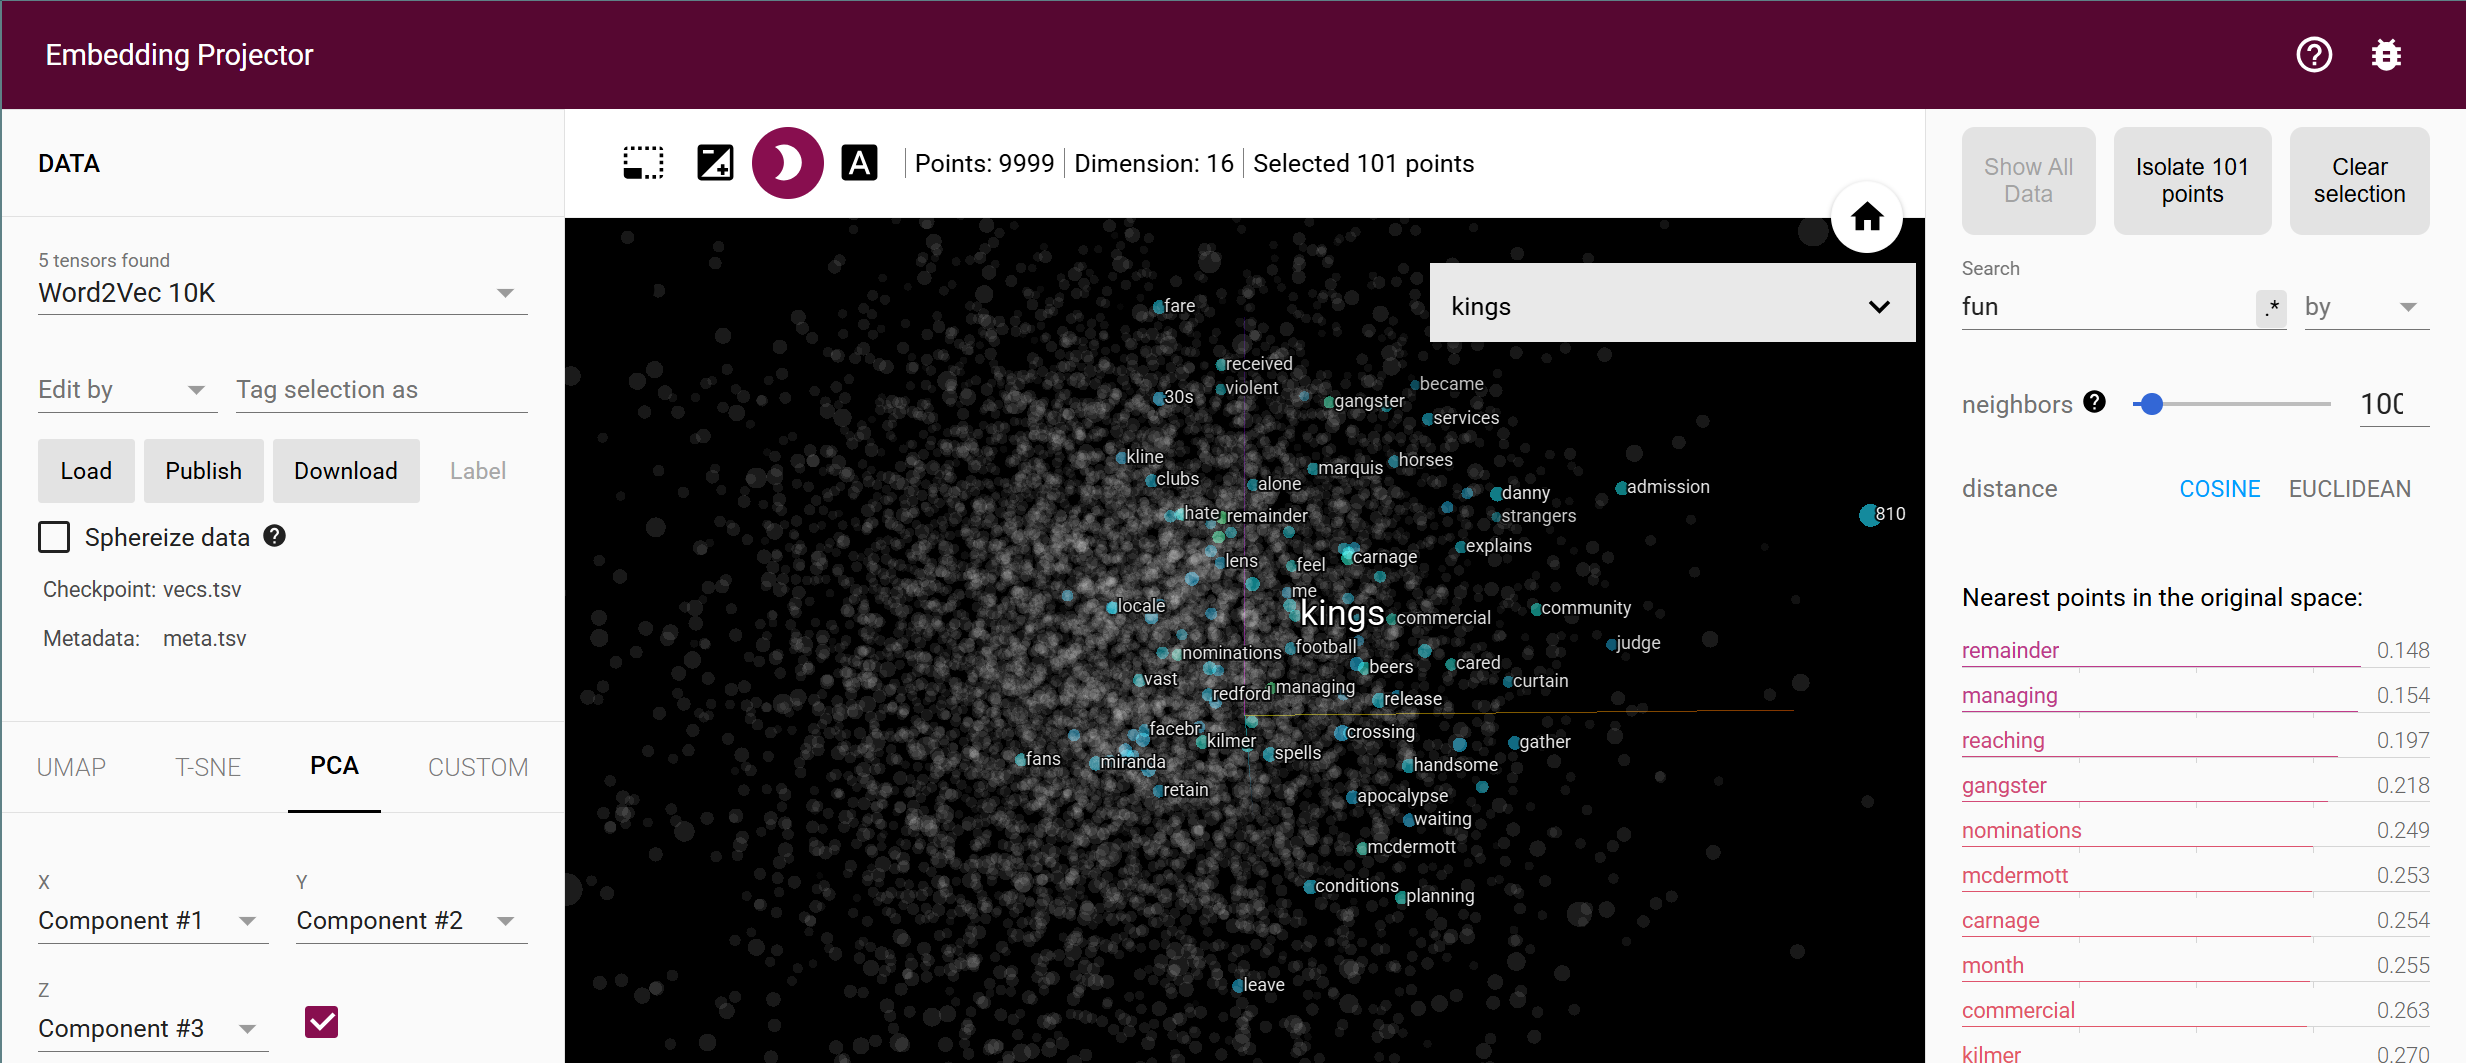